# Assignment 2A: EEG and Event-Related Potentials
Please submit this assignment to Canvas as a jupyter notebook (.ipynb).  The assignment will introduce you to EEG brain data, as well as some of the techniques and methods used to analyze it.

In [1]:
# imports
import pandas as pd
import cmlreaders as cml
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
from mne.stats import bonferroni_correction
from mne.stats import fdr_correction

## Working with EEG data
We learned how to load basic information about CML experiments and experimental events in assignment 1. Next, we're going to load EEG/iEEG data that correspond to those events.

## Loading Electrode/Channel Data
In order to lead iEEG or EEG data, we will again use the cmlreaders package.  We select a session, instantiate a "Reader" object, and load the data we want.  Beyond the behavioral events, we are also interested in the "contacts", "pairs", and of course the EEG data.

* "contacts" are the individual electrodes.
* "pairs" are the two-electrode pairs in our bipolar referencing scheme.
    * Bipolar reference means that instead of looking at the signal recorded by each electrode individually, we take signal of two nearby electrodes and subtract one ('contact_1') from the other ('contact_2').  In a sense, we have a recording channel that is sort of a virtual electrode.
    
## Referencing
Electrical potentials inherently reflect some kind of differential. In the case of EEG data, the voltage fluctuations we measure really reflect a difference between an electrode of interest and a "reference" electrode placed elsewhere (such as the mastoid or an arbitrary location in the brain). As such, noise on the reference electrode -- and other sources -- can contaminate our measurement of true neural signal in the raw data. 

To solve this, it is common to "re-reference" EEG data to mitigate sources of noise. We could have a whole discussion about different ways to re-reference data, and the advantages/disadvantages of each, but there are two common ways of re-referencing I'll mention here. 

The most common re-reference used in this lab is the **bipolar** reference, in which the signal from each channel is subtracted from its neighbor. The result is an estimate of a cleaner signal that putatively reflects activity at the midpoint of the two physical recording contacts (we sometimes call this midpoint a **virtual electrode**). The bipolar reference has several advantages: (1) it's very simple to implement, (2) it typically does a good job at removing widespread noise, and (3) it ensures that your re-referenced traces reflect activity that is very close to the original electrodes. 

(One downside is that bipolar re-referencing can actually reduce your ability to detect true neural signals, or mislocalize its origin, especially if two adjancent electrodes were detecting a common source of electrical activity.)
<center>
<img src="http://www.bem.fi/book/13/fi/1303.gif">
</center>

In [3]:
# load the dataframe for all sessions
df = cml.get_data_index()

# specify subject and experiment
sub = 'R1111M'
exp = 'FR1'

df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# let's pick the first session
df_sess = df_select.iloc[0]

# instantiate a Reader using session metadata
reader = cml.CMLReader(subject=df_sess['subject'], experiment=df_sess['experiment'], session=df_sess['session'], 
                      localization=df_sess['localization'], montage=df_sess['montage'])

# load events, as we have done before
evs = reader.load('events')
evs.head()

,eegoffset,answer,eegfile,exp_version,experiment,intrusion,is_stim,iscorrect,item_name,item_num,...,protocol,recalled,rectime,serialpos,session,stim_list,stim_params,subject,test,type
0,23207,-999,R1111M_FR1_0_22Jan16_1638,1.05,FR1,-999,0,-999,X,-999,...,r1,0,-999,-999,0,0,[],R1111M,"[0, 0, 0]",SESS_START
1,32311,-999,R1111M_FR1_0_22Jan16_1638,1.05,FR1,-999,0,-999,X,-999,...,r1,0,-999,-999,0,0,[],R1111M,"[0, 0, 0]",COUNTDOWN_START
2,37524,-999,R1111M_FR1_0_22Jan16_1638,1.05,FR1,-999,0,-999,X,-999,...,r1,0,-999,-999,0,0,[],R1111M,"[0, 0, 0]",COUNTDOWN_END
3,39379,-999,R1111M_FR1_0_22Jan16_1638,1.05,FR1,-999,0,-999,WATCH,-1,...,r1,0,-999,0,0,0,[],R1111M,"[0, 0, 0]",PRACTICE_WORD
4,40579,-999,R1111M_FR1_0_22Jan16_1638,1.05,FR1,-999,0,-999,RHINO,-1,...,r1,0,-999,1,0,0,[],R1111M,"[0, 0, 0]",PRACTICE_WORD


In [4]:
# load contacts
contacts = reader.load('contacts')
contacts

,contact,label,description,id,type,avg.region,avg.x,avg.y,avg.z,avg.dural.region,...,vox.y,vox.z,wb.region,wb.x,wb.y,wb.z,stein.region,stein.x,stein.y,stein.z
0,1,LPOG1,None,lpog.1,G,middletemporal,-65.25,-18.69,-26.16,middletemporal,...,262,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,LPOG2,None,lpog.2,G,middletemporal,-67.03,-17.97,-16.69,middletemporal,...,260,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,LPOG3,None,lpog.3,G,superiortemporal,-65.64,-17.37,-4.98,superiortemporal,...,258,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,LPOG4,None,lpog.4,G,superiortemporal,-61.69,-17.78,5.82,superiortemporal,...,258,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,LPOG5,None,lpog.5,G,postcentral,-59.29,-17.16,16.71,postcentral,...,256,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,LPS4,None,lps.4,S,middletemporal,-57.52,-0.72,-33.53,middletemporal,...,227,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,97,LTD1,None,ltd.1,D,parahippocampal,-23.77,-25.26,-24.69,parahippocampal,...,274,73,Left PHG parahippocampal gyrus,NaN,NaN,NaN,Left EC,NaN,NaN,NaN
97,98,LTD2,"WM, partial BA35",ltd.2,D,None,-27.88,-22.18,-24.43,None,...,268,73,Left Cerebral White Matter,NaN,NaN,NaN,Left MTL WM,NaN,NaN,NaN
98,99,LTD3,BA35,ltd.3,D,None,-33.02,-20.13,-23.39,None,...,264,74,Left PHG parahippocampal gyrus,NaN,NaN,NaN,Left PRC,NaN,NaN,NaN


In [5]:
# load pairs
pairs = reader.load('pairs')
pairs

,contact_1,contact_2,label,id,is_explicit,is_stim_only,type_1,type_2,avg.region,avg.x,...,wb.x,wb.y,wb.z,stein.region,stein.x,stein.y,stein.z,mni.x,mni.y,mni.z
0,1,9,LPOG1-LPOG9,lpog.1-lpog.9,False,False,G,G,middletemporal,-65.295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65.28000,-24.479300,-25.704682
1,1,2,LPOG1-LPOG2,lpog.1-lpog.2,False,False,G,G,middletemporal,-66.140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-67.32435,-20.277700,-20.704405
2,2,10,LPOG2-LPOG10,lpog.2-lpog.10,False,False,G,G,middletemporal,-67.055,...,NaN,NaN,NaN,Left Middle Temporal Gyrus,NaN,NaN,NaN,-68.17790,-24.273700,-16.147723
3,2,3,LPOG2-LPOG3,lpog.2-lpog.3,False,False,G,G,middletemporal,-66.335,...,NaN,NaN,NaN,Left Middle Temporal Gyrus,NaN,NaN,NaN,-67.85235,-18.974050,-11.785856
4,3,4,LPOG3-LPOG4,lpog.3-lpog.4,False,False,G,G,superiortemporal,-63.665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65.81390,-16.246800,-0.170758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,94,95,LPS2-LPS3,lps.2-lps.3,False,False,S,S,inferiortemporal,-48.050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-50.32230,-1.714042,-45.288351
137,95,96,LPS3-LPS4,lps.3-lps.4,False,False,S,S,middletemporal,-55.070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-57.81460,-0.218944,-36.750696
138,97,98,LTD1-LTD2,ltd.1-ltd.2,False,False,D,D,parahippocampal,-25.825,...,NaN,NaN,NaN,Left MTL WM,NaN,NaN,NaN,-26.55900,-19.346450,-24.104513
139,98,99,LTD2-LTD3,ltd.2-ltd.3,False,False,D,D,None,-30.450,...,NaN,NaN,NaN,Left PRC,NaN,NaN,NaN,-30.96920,-18.622350,-25.020927


Some key info about these dataframes: 
* label: The clinical label for each electrode, as determined in the hospital
* ind.region: The anatomical region using the Desikan-Killiany atlas. 
* ind.x/y/z: Electrode coordinates in individual FreeSurfer space. 
* avg.x/y/z: Electrode coordintes in average FreeSurfer space. 
* tal.x/y/z or mni.x/y/z: Coordinates in Talairach or MNI space. 
* stein.region or das.region: Manually-confirmed labels for MTL subfields (mostly). Talk to me offline about getting these labels for recent subjects.

(The x axis points to the right, the y axis to the front, and the z axis up.)

* For a full description of fields in 'pairs' or 'contacts' structures, see: https://github.com/pennmem/neurorad_pipeline/blob/master/RELEASE_NOTES.md
* For more information on brain coordinate systems, see: http://www.fieldtriptoolbox.org/faq/how_are_the_different_head_and_mri_coordinate_systems_defined/

## Question 1: Electrodes in the Brain
For this question, we will use the term "electrode" to refer to individual contacts, as opposed to bipolar referenced virtual "electrodes".  In other words, use the contacts dataframe (not the pairs dataframe) to answer the following.

1) How many electrodes does R1111M have placed in the temporal cortex?
2) How many electrodes does R1111M have on the left hemisphere and how many on the right hemisphere?

In [6]:
# Question 1.1
### YOUR CODE HERE

In [7]:
# Question 1.2
### YOUR CODE HERE

## Loading iEEG/EEG Data
Finally, to the intersting brain data!  To load EEG, use the "Reader" object's **'load_eeg'** method.  Pass as arguments the events (dataframe) you want to load EEG for, when you want to start/stop the EEG clip (in ms), and the electrodes you want.

* Note that events and electrodes dataframes must be passed as slices, not individual rows. So index them like 'pairs[0:1]' or 'pairs.loc[0:1]' for the first electrode pair, not 'pairs.loc[0]'. Same goes for events!
* We want to use the bipolar referenced data, so for our scheme we will always pass in bipolar channels (i.e. pairs not contacts). 
* The 'clean' argument should be set to True for scalp EEG, but not passed for intracranial EEG.

In [19]:
# let's take a look at the 'load_eeg' method
reader.load_eeg?

Signature:
reader.load_eeg(
    events: Optional[pandas.core.frame.DataFrame] = None,
    rel_start: int = None,
    rel_stop: int = None,
    scheme: Optional[pandas.core.frame.DataFrame] = None,
    clean: Optional[bool] = False,
)
Docstring:
Load EEG data.

Parameters
----------
events
    Events to load EEG epochs from. Incompatible with passing
    ``epochs``.
rel_start
    Start time in ms relative to passed event onsets. This parameter is
    required when passing events and not used otherwise.
rel_stop
    Stop time in ms relative to passed event onsets. This  parameter is
    required when passing events and not used otherwise.
scheme
    When specified, a bipolar scheme to rereference the data with
    and/or filter by channel. Rereferencing is only possible if the
    data were recorded in monopolar (a.k.a. common reference) mode.
    (Currently available for iEEG only.)
clean
    If True, load re-referenced, filtered, and ICA/LCF-cleaned version
    of data (currently avail

In [20]:
# let's select out encoding events
word_evs = evs[evs['type'] == 'WORD']

# let's load EEG from 100 ms before until 1600 ms after each encoding event for all electrode pairs
# this gets us an eeg container object that holds the eeg plus relevant metadata
eeg_container = reader.load_eeg(events=word_evs, rel_start=-100, rel_stop=1600, scheme=pairs)

# specifically select out the EEG data
eeg = eeg_container.data

# grab the sampling rate (samples/s)
samplingrate = eeg_container.samplerate
samplingrate

500

In [21]:
# the EEG is stored in an array with dimensions [events, electrodes, samples]
print(eeg.shape)

# show the EEG data
eeg

(288, 141, 850)


array([[[  6083,   6077,   6065, ...,   6306,   6299,   6296],
        [  7234,   7223,   7212, ...,   7166,   7170,   7174],
        [ -4963,  -4963,  -4964, ...,  -4948,  -4952,  -4967],
        ...,
        [  7691,   7686,   7683, ...,   7785,   7780,   7778],
        [-10164, -10160, -10154, ..., -10242, -10240, -10238],
        [ -1447,  -1448,  -1451, ...,  -1400,  -1396,  -1400]],

       [[  6300,   6290,   6283, ...,   5965,   5959,   5950],
        [  7202,   7193,   7184, ...,   7013,   7015,   7018],
        [ -4964,  -4961,  -4950, ...,  -5019,  -5025,  -5034],
        ...,
        [  7712,   7707,   7703, ...,   7668,   7660,   7651],
        [-10204, -10195, -10189, ..., -10201, -10200, -10194],
        [ -1429,  -1426,  -1421, ...,  -1423,  -1428,  -1428]],

       [[  6059,   6069,   6072, ...,   6338,   6340,   6344],
        [  6888,   6886,   6876, ...,   7096,   7113,   7135],
        [ -4731,  -4722,  -4717, ...,  -4886,  -4888,  -4895],
        ...,
        [  7

In [22]:
# we can do further filtering
# here we select only the first 10 word events, and only channels 15 to 30
eeg_filt = eeg[:10, 15:31, :]
print(eeg_filt.shape)
eeg_filt

(10, 16, 850)


array([[[-4620, -4622, -4618, ..., -4968, -4965, -4950],
        [-3812, -3817, -3817, ..., -4088, -4081, -4089],
        [  549,   549,   551, ...,   509,   507,   515],
        ...,
        [ 8011,  7999,  7980, ...,  8131,  8142,  8144],
        [-7808, -7824, -7840, ..., -7541, -7553, -7563],
        [ 3653,  3655,  3659, ...,  3615,  3620,  3605]],

       [[-4868, -4869, -4867, ..., -4802, -4793, -4782],
        [-4062, -4058, -4049, ..., -3971, -3969, -3966],
        [  499,   491,   481, ...,   516,   521,   531],
        ...,
        [ 8121,  8122,  8139, ...,  7981,  7982,  7978],
        [-7516, -7521, -7529, ..., -7209, -7186, -7165],
        [ 3566,  3566,  3562, ...,  3498,  3501,  3509]],

       [[-4799, -4795, -4792, ..., -4817, -4810, -4808],
        [-3902, -3905, -3913, ..., -4128, -4115, -4104],
        [  488,   492,   500, ...,   559,   552,   544],
        ...,
        [ 7878,  7893,  7911, ...,  8170,  8183,  8191],
        [-7537, -7536, -7543, ..., -7182, -71

#### MNE and PTSA
The lab uses two packages, mne and ptsa, to work with EEG data.  Long story short, these libraries make it easier to analyze EEG data, so when we load EEG we will always want to immediately convert it to one of these formats.

In [23]:
# use the ptsa library
eeg_ptsa = eeg_container.to_ptsa()
eeg_ptsa

<xarray.TimeSeries (event: 288, channel: 141, time: 850)>
array([[[  6083,   6077,   6065, ...,   6306,   6299,   6296],
        [  7234,   7223,   7212, ...,   7166,   7170,   7174],
        [ -4963,  -4963,  -4964, ...,  -4948,  -4952,  -4967],
        ...,
        [  7691,   7686,   7683, ...,   7785,   7780,   7778],
        [-10164, -10160, -10154, ..., -10242, -10240, -10238],
        [ -1447,  -1448,  -1451, ...,  -1400,  -1396,  -1400]],

       [[  6300,   6290,   6283, ...,   5965,   5959,   5950],
        [  7202,   7193,   7184, ...,   7013,   7015,   7018],
        [ -4964,  -4961,  -4950, ...,  -5019,  -5025,  -5034],
        ...,
        [  7712,   7707,   7703, ...,   7668,   7660,   7651],
        [-10204, -10195, -10189, ..., -10201, -10200, -10194],
        [ -1429,  -1426,  -1421, ...,  -1423,  -1428,  -1428]],

       [[  6059,   6069,   6072, ...,   6338,   6340,   6344],
        [  6888,   6886,   6876, ...,   7096,   7113,   7135],
        [ -4731,  -4722,  -4717, ...,  -4886,  -4888,  -4895],
        ...,
...
        [  7812,   7808,   7802, ...,   7636,   7642,   7642],
        [-10168, -10168, -10175, ..., -10157, -10159, -10158],
        [ -1395,  -1392,  -1385, ...,  -1384,  -1386,  -1385]],

       [[  6166,   6173,   6181, ...,   6104,   6095,   6084],
        [  7140,   7142,   7137, ...,   6991,   6982,   6979],
        [ -4910,  -4910,  -4908, ...,  -4993,  -4993,  -4998],
        ...,
        [  7809,   7811,   7815, ...,   7705,   7703,   7703],
        [-10256, -10253, -10249, ..., -10158, -10160, -10161],
        [ -1453,  -1451,  -1457, ...,  -1427,  -1424,  -1423]],

       [[  6180,   6180,   6181, ...,   6149,   6164,   6170],
        [  7158,   7154,   7151, ...,   7039,   7042,   7037],
        [ -5009,  -5016,  -5022, ...,  -4827,  -4817,  -4797],
        ...,
        [  7787,   7782,   7778, ...,   7767,   7766,   7765],
        [-10259, -10255, -10256, ..., -10288, -10288, -10288],
        [ -1372,  -1375,  -1373, ...,  -1399,  -1397,  -1395]]],
      dtype=int16)
Coordinates: (12/28)
  * event        (event) object MultiIndex
  * answer       (event) int64 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
  * eegfile      (event) object '/protocols/r1/subjects/R1111M/experiments/FR...
  * eegoffset    (event) int64 100520 101829 103113 ... 1411185 1412435 1413685
  * exp_version  (event) object '1.05' '1.05' '1.05' ... '1.05' '1.05' '1.05'
  * experiment   (event) object 'FR1' 'FR1' 'FR1' 'FR1' ... 'FR1' 'FR1' 'FR1'
    ...           ...
  * subject      (event) object 'R1111M' 'R1111M' 'R1111M' ... 'R1111M' 'R1111M'
  * test         (event) object (0, 0, 0) (0, 0, 0) ... (0, 0, 0) (0, 0, 0)
  * type         (event) object 'WORD' 'WORD' 'WORD' ... 'WORD' 'WORD' 'WORD'
  * channel      (channel) <U13 'LPOG1-LPOG9' 'LPOG1-LPOG2' ... 'LTD3-LTD4'
  * time         (time) float64 -100.0 -98.0 -96.0 ... 1.596e+03 1.598e+03
    samplerate   float64 500.0

In [24]:
# use the mne library
eeg_mne = eeg_container.to_mne()
eeg_mne._data

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 24 columns


array([[[  6083.,   6077.,   6065., ...,   6306.,   6299.,   6296.],
        [  7234.,   7223.,   7212., ...,   7166.,   7170.,   7174.],
        [ -4963.,  -4963.,  -4964., ...,  -4948.,  -4952.,  -4967.],
        ...,
        [  7691.,   7686.,   7683., ...,   7785.,   7780.,   7778.],
        [-10164., -10160., -10154., ..., -10242., -10240., -10238.],
        [ -1447.,  -1448.,  -1451., ...,  -1400.,  -1396.,  -1400.]],

       [[  6300.,   6290.,   6283., ...,   5965.,   5959.,   5950.],
        [  7202.,   7193.,   7184., ...,   7013.,   7015.,   7018.],
        [ -4964.,  -4961.,  -4950., ...,  -5019.,  -5025.,  -5034.],
        ...,
        [  7712.,   7707.,   7703., ...,   7668.,   7660.,   7651.],
        [-10204., -10195., -10189., ..., -10201., -10200., -10194.],
        [ -1429.,  -1426.,  -1421., ...,  -1423.,  -1428.,  -1428.]],

       [[  6059.,   6069.,   6072., ...,   6338.,   6340.,   6344.],
        [  6888.,   6886.,   6876., ...,   7096.,   7113.,   7135.],
    

In [25]:
# again we can filter the data as before
eeg_ptsa_filt = eeg_ptsa[:10, 15:31, :]
print(eeg_ptsa_filt.shape)
eeg_ptsa_filt

(10, 16, 850)


<xarray.TimeSeries (event: 10, channel: 16, time: 850)>
array([[[-4620, -4622, -4618, ..., -4968, -4965, -4950],
        [-3812, -3817, -3817, ..., -4088, -4081, -4089],
        [  549,   549,   551, ...,   509,   507,   515],
        ...,
        [ 8011,  7999,  7980, ...,  8131,  8142,  8144],
        [-7808, -7824, -7840, ..., -7541, -7553, -7563],
        [ 3653,  3655,  3659, ...,  3615,  3620,  3605]],

       [[-4868, -4869, -4867, ..., -4802, -4793, -4782],
        [-4062, -4058, -4049, ..., -3971, -3969, -3966],
        [  499,   491,   481, ...,   516,   521,   531],
        ...,
        [ 8121,  8122,  8139, ...,  7981,  7982,  7978],
        [-7516, -7521, -7529, ..., -7209, -7186, -7165],
        [ 3566,  3566,  3562, ...,  3498,  3501,  3509]],

       [[-4799, -4795, -4792, ..., -4817, -4810, -4808],
        [-3902, -3905, -3913, ..., -4128, -4115, -4104],
        [  488,   492,   500, ...,   559,   552,   544],
        ...,
...
        ...,
        [ 8089,  8084,  8086, ...,  8007,  8026,  8050],
        [-7478, -7484, -7477, ..., -7663, -7662, -7668],
        [ 3489,  3488,  3489, ...,  3557,  3550,  3547]],

       [[-4525, -4516, -4511, ..., -4801, -4790, -4780],
        [-3737, -3740, -3747, ..., -4071, -4064, -4057],
        [  393,   395,   394, ...,   450,   439,   432],
        ...,
        [ 8025,  8028,  8026, ...,  8246,  8236,  8225],
        [-7536, -7542, -7546, ..., -7360, -7344, -7328],
        [ 3231,  3207,  3188, ...,  3595,  3587,  3578]],

       [[-4843, -4835, -4829, ..., -4762, -4755, -4751],
        [-4069, -4062, -4068, ..., -4060, -4047, -4031],
        [  509,   501,   499, ...,   524,   512,   501],
        ...,
        [ 8088,  8107,  8108, ...,  8248,  8245,  8240],
        [-7410, -7414, -7417, ..., -7429, -7422, -7412],
        [ 3583,  3576,  3566, ...,  3369,  3359,  3358]]], dtype=int16)
Coordinates: (12/28)
  * event        (event) object MultiIndex
  * answer       (event) int64 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
  * eegfile      (event) object '/protocols/r1/subjects/R1111M/experiments/FR...
  * eegoffset    (event) int64 100520 101829 103113 ... 109372 110580 111813
  * exp_version  (event) object '1.05' '1.05' '1.05' ... '1.05' '1.05' '1.05'
  * experiment   (event) object 'FR1' 'FR1' 'FR1' 'FR1' ... 'FR1' 'FR1' 'FR1'
    ...           ...
  * subject      (event) object 'R1111M' 'R1111M' 'R1111M' ... 'R1111M' 'R1111M'
  * test         (event) object (0, 0, 0) (0, 0, 0) ... (0, 0, 0) (0, 0, 0)
  * type         (event) object 'WORD' 'WORD' 'WORD' ... 'WORD' 'WORD' 'WORD'
  * channel      (channel) <U13 'LPOG9-LPOG17' ... 'LPOG17-LPOG25'
  * time         (time) float64 -100.0 -98.0 -96.0 ... 1.596e+03 1.598e+03
    samplerate   float64 500.0

In [26]:
# we can use some mne methods for filtering
print(eeg_mne.ch_names[:5])     # we can get the channel names
eeg_mne_filt = eeg_mne.pick(eeg_mne.ch_names[:5])     # and pick specific channels
print(eeg_mne_filt.get_data().shape)

['LPOG1-LPOG9', 'LPOG1-LPOG2', 'LPOG2-LPOG10', 'LPOG2-LPOG3', 'LPOG3-LPOG4']
(288, 5, 850)


#### Plotting a Voltage Trace
Let's visualize the EEG recorded from 1 channel.

Text(0.5, 1.0, 'Sample EEG trace')

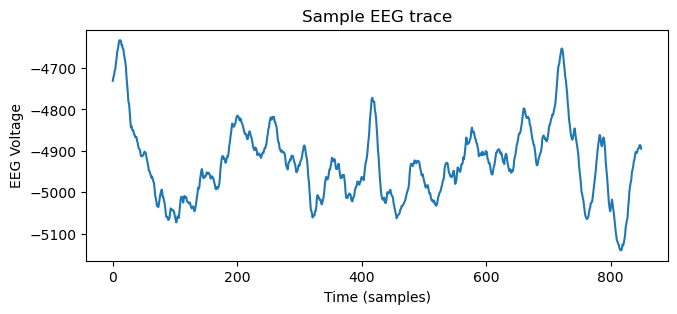

In [27]:
# Plot an example EEG trace
plt.figure(figsize=(7.5, 3)); ax=plt.subplot(111)
plt.plot(eeg[2, 2, :])
plt.ylabel('EEG Voltage'); plt.xlabel('Time (samples)')
plt.title('Sample EEG trace')

This is the fundamental unit of all of the analyses you'll do in the lab -- the EEG timeseries! Whether from scalp or intracranial data, our core interest is understanding the properties of these timeseries relative to interesting behavioral or cognitive events. Typically, we understand EEG signals with **spectral decomposition**, which will be covered in a future assignment.  Below is some code that will z-score a voltage trace.  Recall the definition of a Z-score:
$$
Z = \frac{x-\mu}{\sigma}
$$
where x is the observed value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

/home1/hherrema/.conda/envs/bids/lib/python3.11/site-packages/cmlreaders/readers/eeg.py:563: UserWarning: Some events have eegoffset < 0 and will be dropped.
  warnings.warn("Some events have eegoffset < 0 and will be dropped.")


avg.region: cuneus
(288, 1, 850)
(288, 1, 850)


Text(0, 0.5, 'Z-scored Voltage')

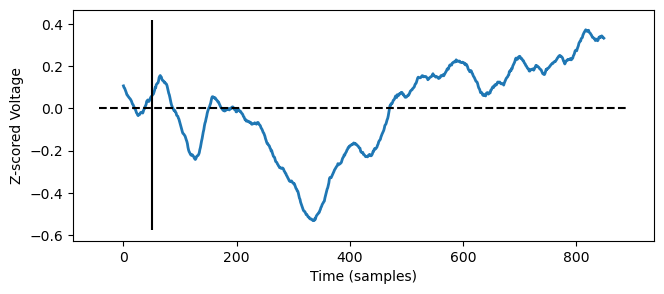

In [28]:
# load 1700ms long EEG events from 100ms before event to 1600ms after
eeg_container = reader.load_eeg(evs, -100, 1600, scheme=pairs)
eeg = eeg_container.data
sr = eeg_container.samplerate

# select word encoding events for channel 112 (as a slice), keeping events, channels, time
# channel 112 is in the cuneus, part of the occipital lobe
eeg = eeg[word_evs.index, 112:113]
print('avg.region:', pairs.iloc[112]['avg.region'])
print(eeg.shape)

# calculate mean (average over time and then event)
mu = np.mean(np.mean(eeg[:, 0, :], 1), 0)
# calculate standard deviation between events (first averaging over time)
std_ = np.std(np.mean(eeg[:, 0, :], 1), 0)

# z-score
zeeg = (eeg-mu)/std_
print(zeeg.shape)

# Plot the trace averaged across all events
plt.figure(figsize=(7.5, 3)); ax=plt.subplot(111)
plt.plot(np.mean(zeeg[:, 0, :], 0), linewidth=2,)
plt.vlines([0.1*sr], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='-', color='k')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.xlabel('Time (samples)'); plt.ylabel('Z-scored Voltage')

## Question 2
Now we will compare z-scored voltage traces for encoded words that were subsequently recalled vs. not recalled.  This sort of "Subsequent Memory Effect" (SME) analysis is of great interest, since it allows us to get at the question of what neural features underlie successful memory.

1) Plot the Z-scored ERP for a 2-second span (-400 ms to 1600 ms) surrounding each word encoding event for a lateral occipital electrode from R1383J's first FR1 session.  We want to two lines on our plot, one averaging over words that were subsequently recalled, and one averaging over words that were not later recalled.
* Add vertical and horizontal lines on your plot to indicate word onset and Z = 0, respectively.
* Add a legend and label each line (Rec v. NRec)


2) Does the occipital electrode show an effect?

In [29]:
# Question 2.1
### YOUR CODE HERE

Question 2.2

**YOUR ANSWER HERE**

## Event Related Potentials (ERPs)

In cognitive electrophysiology, we are interested in the mapping between behavior and neuroscience.  Event related potentials give us a foundational method for investigating this mapping.  Specifically, an ERP shows us what the brain (EEG) looks like in correspondance to a specific behavioral event -- for example, the onset of a word presentation.  The key characteristic of an ERP is that we want to baseline correct the voltage trace prior to the event of interest (i.e. subtract the average), such that we can see specifically what effect the behavioral event has on the neural signal.

For the remaining exercises in this assignment, we will be analyzing these ERPs.  You will be working with data from a single electrode 75 (Oz) (labeled 'E75') in a single subject LTP093 for LTPFR2 experimental sessions. In this and all subsequent exercises, you will analyze the time series of data surrounding each word presentation, from 200 ms prior to word onset until 1,000 ms after word onset. To remove electrical signals that do not reflect neural activity, we use the Localized Component Filtering method (DelPozo-Banos & Weidemann, 2017). To load the LCF-cleaned
data you will pass the clean=True argument to the CMLReader’s load_eeg() method.

A few points:

* The LTPFR2 data set you'll be working with for this assignment is a *scalp EEG* data set and has slightly different column definitions than intracranial EEG sessions.  For example, the 'trial' column indicates the list number of the event.
* If you use array indexing to access electrode 75 (as opposed to e.g., xarray indexing), make sure to double check the index for this contact.
* Load the scalp EEG data with the `load_eeg()` function by setting the argument `clean=True` and simply don't include the `scheme` argument in the function call to `load_eeg()`. The scheme is only needed for intracranial data and indicates whether monopolar or bipolar-rereferenced EEG should be loaded and for which contacts/bipolar pairs.
* Make sure to subset the events to just the WORD or REC_WORD events before loading the EEG. CMLReaders won't load overlapping EEG intervals (i.e. epochs) surrounding events, which will happen if you try to load EEG surrounding all the behavioral events.  Here is some example code:

In [30]:
exp = 'ltpFR2'                      # LTPFR2 experiment
df = cml.get_data_index('ltp')
df = df.query("experiment == @exp")     # select only LTPFR2 sessions
df

,all_events,experiment,import_type,math_events,original_session,session,subject,subject_alias,task_events
487,protocols/ltp/subjects/LTP093/experiments/ltpF...,ltpFR2,build,protocols/ltp/subjects/LTP093/experiments/ltpF...,0,0,LTP093,LTP093,protocols/ltp/subjects/LTP093/experiments/ltpF...
488,protocols/ltp/subjects/LTP093/experiments/ltpF...,ltpFR2,build,protocols/ltp/subjects/LTP093/experiments/ltpF...,1,1,LTP093,LTP093,protocols/ltp/subjects/LTP093/experiments/ltpF...
489,protocols/ltp/subjects/LTP093/experiments/ltpF...,ltpFR2,build,protocols/ltp/subjects/LTP093/experiments/ltpF...,10,10,LTP093,LTP093,protocols/ltp/subjects/LTP093/experiments/ltpF...
490,protocols/ltp/subjects/LTP093/experiments/ltpF...,ltpFR2,build,protocols/ltp/subjects/LTP093/experiments/ltpF...,11,11,LTP093,LTP093,protocols/ltp/subjects/LTP093/experiments/ltpF...
491,protocols/ltp/subjects/LTP093/experiments/ltpF...,ltpFR2,build,protocols/ltp/subjects/LTP093/experiments/ltpF...,12,12,LTP093,LTP093,protocols/ltp/subjects/LTP093/experiments/ltpF...
...,...,...,...,...,...,...,...,...,...
6526,protocols/ltp/subjects/LTP393/experiments/ltpF...,ltpFR2,build,protocols/ltp/subjects/LTP393/experiments/ltpF...,5,5,LTP393,LTP393,protocols/ltp/subjects/LTP393/experiments/ltpF...
6527,protocols/ltp/subjects/LTP393/experiments/ltpF...,ltpFR2,build,protocols/ltp/subjects/LTP393/experiments/ltpF...,6,6,LTP393,LTP393,protocols/ltp/subjects/LTP393/experiments/ltpF...
6528,protocols/ltp/subjects/LTP393/experiments/ltpF...,ltpFR2,build,protocols/ltp/subjects/LTP393/experiments/ltpF...,7,7,LTP393,LTP393,protocols/ltp/subjects/LTP393/experiments/ltpF...
6529,protocols/ltp/subjects/LTP393/experiments/ltpF...,ltpFR2,build,protocols/ltp/subjects/LTP393/experiments/ltpF...,8,8,LTP393,LTP393,protocols/ltp/subjects/LTP393/experiments/ltpF...


In [41]:
sess_df = df.iloc[0]  # grab meta-data for first session in LTPFR2 data set

# get a data reader as before, but without the montage and localization arguments
reader = cml.CMLReader(subject=sess_df.subject,
                       session=sess_df.session,
                       experiment=sess_df.experiment)

# load the behavioral events for this session
evs = reader.load('events')
word_evs = evs[evs['type'] == 'WORD']

# load the eeg --> for scalp EEG we want to specify clean = True)
eeg = reader.load_eeg(events=word_evs, rel_start = -100, rel_stop = 1000, clean = True).to_ptsa()
eeg

Opening raw data file /protocols/ltp/subjects/LTP093/experiments/ltpFR2/sessions/0/ephys/current_processed/LTP093 20140902 0959.2_clean_raw.fif...
    Range : 0 ... 2858664 =      0.000 ...  5717.328 secs
Ready.
Reading 0 ... 2858664  =      0.000 ...  5717.328 secs...
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 576 events and 551 original time points ...
0 bad epochs dropped


<xarray.TimeSeries (event: 576, channel: 124, time: 551)>
array([[[-5.44548224e-06, -2.31033754e-06, -1.26133752e-06, ...,
         -5.77436827e-06, -6.94353150e-06, -8.80198476e-06],
        [-9.38845537e-06, -7.86169575e-06, -4.78514575e-06, ...,
          1.52607917e-06, -3.10387853e-08, -9.07887552e-06],
        [ 1.38913650e-05,  1.45578575e-05,  7.86829994e-06, ...,
          1.09732179e-05,  1.07329454e-05, -3.39196180e-06],
        ...,
        [ 4.16697930e-06,  5.21644972e-06,  3.70095133e-06, ...,
          5.76517640e-07, -1.17582011e-06, -5.81043910e-06],
        [-2.05874347e-06,  2.71453112e-07, -1.06465220e-06, ...,
         -6.86545704e-06, -7.56921814e-06, -6.37896155e-06],
        [-7.55552826e-07, -8.64813683e-07,  2.31394246e-07, ...,
         -4.81928872e-06, -8.23925779e-06, -8.04741857e-06]],

       [[ 1.17181320e-05,  1.56529312e-05,  1.47506504e-05, ...,
          7.07020424e-06,  3.26276445e-06, -3.31738638e-06],
        [ 1.91926217e-06,  1.01686153e-05,  5.45040988e-06, ...,
          4.89050435e-06,  4.83034550e-07,  2.91767477e-06],
        [-1.62102127e-06,  4.43498896e-06, -3.58390426e-06, ...,
          6.82189463e-06,  6.18200968e-06,  6.07595681e-06],
...
        [ 1.68264544e-06,  1.70072853e-06, -8.53746412e-07, ...,
         -6.44807099e-06, -8.84175108e-06, -6.16033123e-06],
        [ 2.35205864e-06, -4.95025109e-06, -2.16679739e-06, ...,
         -4.91195916e-06, -3.88908624e-06, -3.86504005e-06],
        [-4.24452214e-07,  6.88936783e-08, -8.46136627e-07, ...,
         -5.32955645e-06, -7.12135122e-06, -6.36636303e-06]],

       [[-3.99960064e-06, -1.03470564e-05, -1.15901107e-05, ...,
         -1.62907867e-05, -1.49298906e-05, -1.71170005e-05],
        [-1.00183573e-05, -7.59011553e-06, -3.26234030e-06, ...,
         -1.77438373e-05, -1.38395786e-05, -1.09123583e-05],
        [-9.97141359e-06, -5.90627049e-06, -6.82755409e-07, ...,
         -1.02412081e-05, -7.93762157e-06, -9.34263608e-06],
        ...,
        [-4.08690118e-06, -2.65405154e-06, -1.78929519e-06, ...,
         -1.13761902e-05, -1.02451219e-05, -1.07157964e-05],
        [-3.82428359e-06, -3.91137337e-06, -3.48279213e-06, ...,
         -1.44409961e-05, -1.35250644e-05, -1.34141922e-05],
        [-1.84810137e-06, -3.84987264e-07,  8.30413876e-07, ...,
         -1.12372148e-06, -3.50123524e-06, -3.74488067e-06]]])
Coordinates: (12/32)
  * event               (event) object MultiIndex
  * answer              (event) int64 -999 -999 -999 -999 ... -999 -999 -999
  * begin_distractor    (event) int64 0 0 0 0 0 ... 24000 24000 24000 24000
  * begin_math_correct  (event) int64 -999 -999 -999 -999 -999 ... 12 12 12 12
  * eegfile             (event) object '/protocols/ltp/subjects/LTP093/experi...
  * eegoffset           (event) int64 285929 287177 288442 ... 2768352 2769567
    ...                  ...
  * test                (event) object (0, 0, 0) (0, 0, 0) ... (0, 0, 0)
  * trial               (event) int64 1 1 1 1 1 1 1 1 ... 24 24 24 24 24 24 24
  * type                (event) object 'WORD' 'WORD' 'WORD' ... 'WORD' 'WORD'
  * channel             (channel) <U4 'E1' 'E2' 'E3' ... 'E124' 'E125' 'E128'
  * time                (time) float64 -100.0 -98.0 -96.0 ... 996.0 998.0 1e+03
    samplerate          float64 500.0

### Question 3

1) For each word encoding event in the first list of the first session of the same subject (LTP093) from the previous problem, plot the individual voltage timeseries from 200 ms before the onset of the word until 1000 ms after the onset of the study word. In each figure panel mark study word onset. 

2) Can you identify any consistent patterns in the voltage time series between serial positions just by looking at them?

In [42]:
# Question 3.1
### YOUR CODE HERE

Question 3.2

**YOUR CODE HERE**

### Question 4
1) Generate ERPs for all the events in the first session (subject LTP093) for the first, second, and third serial positions separately (one ERP per serial position) and then an ERP averaged across the events in the remaining serial positions 4 - 24 in Session 1. To carry out an ERP analysis on the voltage data, we must 
    1. Load the desired events.
    2. Filter to only encoding events.
    3. Get the voltage for all encoding events.
    4. Baseline correct the voltage traces separately for each trace by subtracting the average signal from 200 ms before stimulus onset (word presentation) to the stimulus onset (i.e., the "baseline" voltage) from all voltages or values in the trace during the epoch of interest from stimulus onset to 1000 ms post-onset. 
        * Baseline correction accounts for the fact that the electrical activity (or roughly speaking, state) of the brain will differ from event to event when the stimulus is presented. What we care about is how much the stimulus impacts the electrical activity of the brain relative to what it was just prior to the stimulus.
    5. Filter events by serial position.
    6. Plot the average voltage traces for the different groups of serial positions together on a single figure. 
2) Compare the ERPs to the individual time series you plotted earlier. Is it easier to distinguish the serial positions of items when including data from all events?

In [44]:
# Question 4.1
### YOUR CODE HERE

Question 4.2

**YOUR CODE HERE**

### Question 5
1) Again generate ERPs comparing items across the groups of serial positions given in Problem 4, but this time averaging over data from all sessions from the same subject. 

2) Compare the ERPs obtained here with those obtained in the previous exercise.

In [46]:
# Question 5.1
### YOUR CODE HERE

Question 5.2

**YOUR ANSWER HERE**

In [49]:
# Question 6.1
### YOUR CODE HERE

Question 6.2

**YOUR ANSWER HERE**

## Statistical Inference, t-tests, and multiple comparisons
<span style='color:blue'> *The remainder of this notebook is a brief overview of some univariate statistical concepts and examples that will be useful in this assignment and beyond. Feel free to skip it and begin the assignment if you are already familiar.* </span>

For a brief aside on t-tests and how to use them, see: https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-t-tests-t-values-and-t-distributions

### Multiple Comparisons in Statistical Tests

While our goal with this course is not to teach you statistics, we do need to take a slight detour to address some common statistical issues that come up in ECoG analyses. First, we'll touch on the problem of **multiple comparisons** ( https://en.wikipedia.org/wiki/Multiple_comparisons_problem ). This refers to the idea that, if you run many statistical tests, you're more likely to get a false positive with increasing numbers of tests. For example, if a subject has 100 electrodes, and we'd like to test whether there's an increase in power at each electrode, some will -- purely by chance -- show an increase in power even if it's not meaningfully correlated with memory. 

The easiest way to correct for multiple comparisons is to set a more stringent threshold for determining significance. Typically, these thresholds are set as <i>p</i> values, which you're likely quite familiar with. The <i>p</i> value is the proportion of test statistic values that, under the null hypothesis, exceed the true test statistic. If too many null values exceed the true value, it's hard to say that the true value is "significant." But if you set the <i>p</i> value to something very small -- as in, almost no null values exceed the true value -- it becomes quite difficult to find a "significant" result. 

Indeed, the **Bonferonni correction** is a common and simple way to account for the multiple comparisons problem. The basic idea is to take the <i>P</i> value you'd ordinarily use, and divide it by the number of tests you're running. So if usually you'd want a P<0.05 to declare significance, but you run 100 tests, now you'd need a P<0.0005 for significance. This is a very conservative way to control for multiple comparisons (strictly, Bonferonni correction controls for the "familywise error" rate). 

If a test survives Bonferonni correction (and assuming other assumptions about the test were also met), that's a strong indication that there's something real there (i.e. you're not looking at a false positive), and you can make some conclusions about it. Bonferonni falls under the category of **family-wise error rate (FWER) control**, or the probably that *any* test leads to a Type I (false positive) error. 

You'll also see "False Discovery Rate" controlling procedures, or **FDR correction**, in the ECoG literature. These are less conservative tests that let you screen for effects in large amounts of data, but do not offer the same kind of strict control that Bonferonni does (therefore, be more cautious in your interpretation of the "significant" effects.). A common FDR procedure is called "Benjamini-Hochberg," though there are several algorithms with unique properties. FDR correction limits the total *proportion* of Type I errors across all tests.

Many types of correction can be applied using the stats toolbox within MNE. Let's explore a few of these now, and use them on real data. 

<center>
<img src="https://github.com/esolomon/PythonBootcamp2019/blob/master/figures/fwer.png?raw=true" width=300>
<center>

In [32]:
# First, let's load up some data with dimensions [frequencies, electrodes, time bins].
pvals = np.load(os.path.join('sample_files','R1001P_pvals.npy'))

Text(0, 0.5, 'Count')

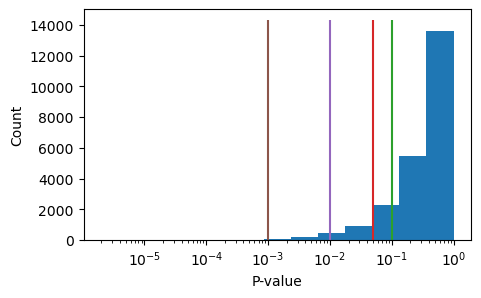

In [33]:
# Let's take a look at the distribution of these p-values.
# Plot a histogram of pvalues on a log scale.
plt.figure(figsize=(5, 3))
ax = plt.subplot(111)
_, bins, _ = plt.hist(pvals.ravel(), bins=13, alpha=0)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(pvals.ravel(), bins=logbins, color='C0')
plt.vlines([0.1, 0.05, 0.01, 0.001], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], 
       colors=('C2', 'C3', 'C4', 'C5'),)
plt.xscale('log')
plt.xlabel('P-value')
plt.ylabel('Count')

It's clear that there aren't many P-values less than 0.001. Would any of these survive Bonferonni correction?

(Perhaps testing individual P-values across all timepoints, frequencies, and electrodes isn't the best approach. What if we restricted ourselves to running tests at the electrode level, for a given time window of interest?)

In [34]:
# Load the raw power values so we can run some tests.
rec = np.load(os.path.join('sample_files', 'R1001P_recalled.npy'))
pows = np.load(os.path.join('sample_files', 'R1001P_pows.npy'))

# pows are dimensions [freqs, events, electrodes, time bins].

# Let's average powers into across the 400-700 ms window.
# This begins after ERP effects die out,
# but not so long as to include irrelevant activity.
# Furthermore, let's only analyze the theta frequencies,
# which were the first 5 (trust me).
avg_pow = np.mean(np.mean(pows[:5, :, :, 4:7], 0), -1)

# avg_pow should be an events X electrodes array. Excellent!
# Let's do our 2-sample T-test on these averaged values
ts, ps = ttest_ind(avg_pow[rec==1, :], avg_pow[rec==0, :], axis=0, equal_var=False)

In [35]:
# If we did an uncorrected test, what would we find?
sig_elecs = ps<0.05

print(ps<0.05)

[False False False False False False  True  True False False False False
  True False  True False False  True  True False  True False False False
 False False False False False False False False False False False False
  True False False False  True False False False False False False False
 False False False False False False  True False False False False  True
  True False  True False False False False False False False False False]


In [36]:
# What about Bonferonni correction?
reject, pval_cor = bonferroni_correction(ps, 0.05)

print(reject)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


No electrodes survive Bonferroni correction! Is it too conservative? Remember that Bonferonni assume **no statistical dependency between tests.** What about FDR correction (Benjamini-Hochberg)?

In [37]:
# FDR correction
reject, pval_cor = fdr_correction(ps, 0.05)  #by default, this implements Benjamini-Hochberg with a 0.05 threshold. 

print(reject)

[False False False False False False  True False False False False False
  True False  True False False False  True False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False]


A few electrodes are back! With this threshold, we would expect, on average, 5% of the significant tests to result in a Type I error. 

The significant electrodes should not be over-interpreted, since we used a less-conservative test. Some still might be false positives. But they may carry interesting signal, and combined with other information, these signals could teach us something about the brain. 